# Guided Backpropagation Saliency map for MF974418_1_Crotalus_atrox

- Gradients: Partial derivatives of the output with respect to input features
- Saliencies: Derived importance measures often based on gradients

In [1]:
import numpy as np

In [39]:
saliency_map = np.load('../output_guided_saliency/MF974418_1_Crotalus_atrox_guided_saliency.npy')
print(saliency_map.shape)

(122, 20, 2560)


In [40]:
positive_saliencies = saliency_map.copy()
positive_saliencies[positive_saliencies < 0] = 0
negative_saliencies = saliency_map.copy()
negative_saliencies[negative_saliencies > 0] = 0
absolute_saliencies = np.abs(saliency_map.copy())

In [41]:
saliency_map[0]

array([[-0.00152234,  0.04478321, -0.02089859, ..., -0.01670561,
         0.0356981 , -0.00663934],
       [ 0.00044014,  0.04718379, -0.01875024, ..., -0.01828321,
         0.02944266, -0.00428554],
       [ 0.01000899,  0.0352353 , -0.0100402 , ..., -0.01353781,
         0.00946805, -0.01500299],
       ...,
       [ 0.01020597,  0.04424816, -0.00727696, ..., -0.03173996,
         0.02286159, -0.01073923],
       [ 0.00916623,  0.04349127, -0.01733734, ..., -0.03236062,
         0.01877348,  0.00202268],
       [ 0.01221179,  0.04975877, -0.01771044, ..., -0.03357029,
         0.01912684, -0.00126132]])

In [42]:
saliency_map[0].shape

(20, 2560)

In [43]:
# load the sequence from the fasta file 
fasta_path = '../data/MF974418_1_Crotalus_atrox.fasta'
with open(fasta_path) as f: 
    fasta = f.readlines()
    sequence = ''.join(fasta[1:]).replace('\n', '')
print(sequence)

SLVQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFVHDCCYGKATDCNPKTVSYTYSEENGEIICGGDDPCGTQICECDKAAAICFRDNIPSYDNKYWLFPPKNCREEPEPC


In [44]:
# Check where all elements in the third dimension (=gradients) are zero
all_zero = np.all(saliency_map == 0, axis=2)
zero_indices = np.argwhere(all_zero)

In [45]:
alphabet = "ACDEFGHIKLMNPQRSTVWY"
# check whether for these pairs (x,y), the sequence[x] is equal to alphabet[y]
not_equal = 0
equal = 0   
for i, j in zero_indices:
    if sequence[i] != alphabet[j]:
        not_equal += 1
    else:
        equal += 1
print(not_equal, equal)

0 122


Saliency map seems to be fine. 

Next step: Analyse it

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import pandas as pd
import sys 
sys.path.append('../vespag')

from parse.vep_scores import get_vespag_scores

GEMME_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"

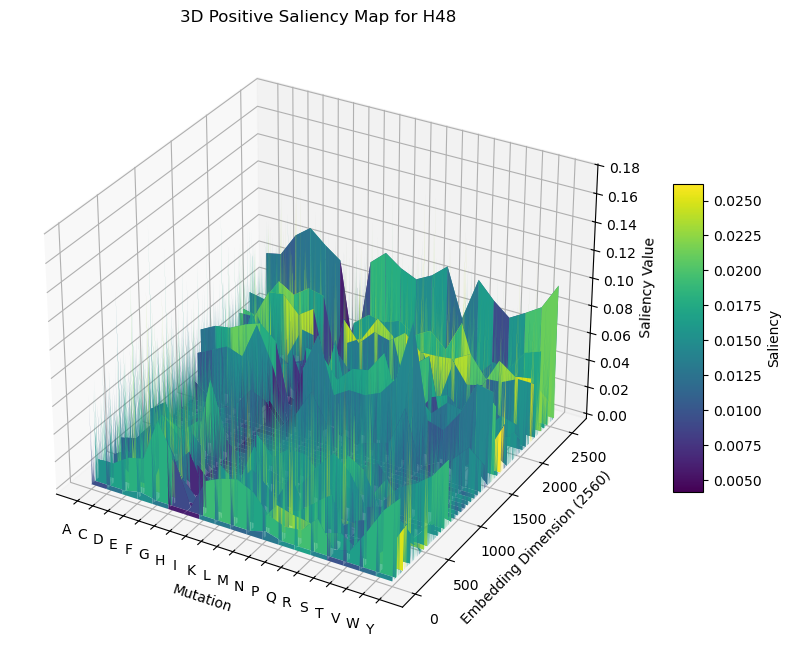

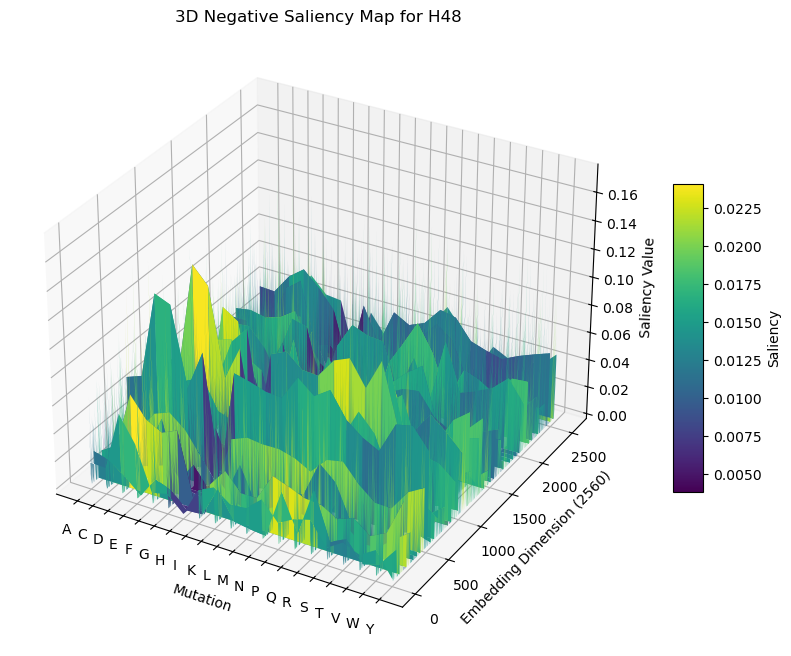

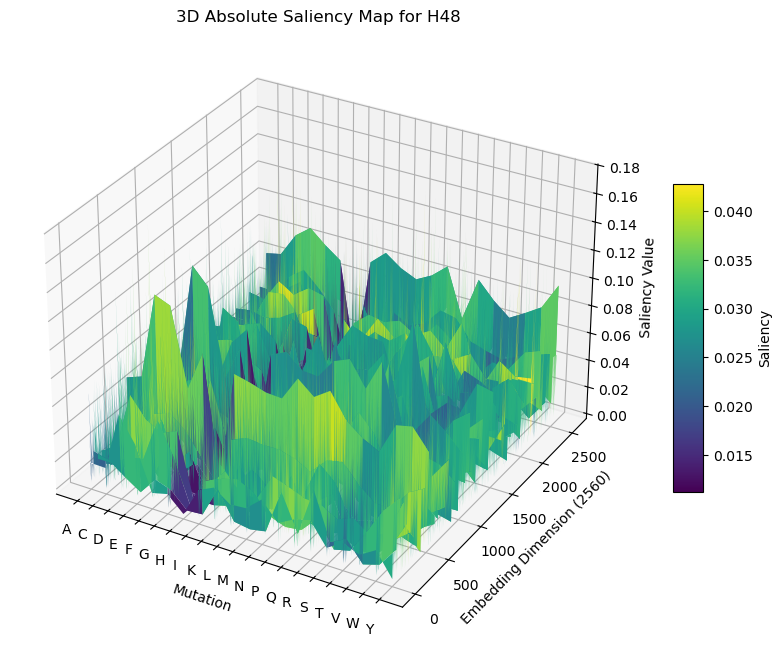

In [66]:
def plot_saliency_3d(saliency_map, residue_index, title="3D Saliency Map"):
    slice_saliency = saliency_map[residue_index]  # Shape: (20, 2560)

    # Create grid for 3D surface
    x = np.arange(slice_saliency.shape[0])  # Mutation index (20 amino acids)
    y = np.arange(slice_saliency.shape[1])  # Embedding dimensions (2560)
    x, y = np.meshgrid(x, y)
    z = slice_saliency.T  # Transpose to match grid shape

    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, z, cmap='viridis')

    # Add labels and title
    ax.set_title(title)
    ax.set_xlabel("Mutation")
    ax.set_ylabel("Embedding Dimension (2560)")
    ax.set_zlabel("Saliency Value")
    ax.set_xticks(np.arange(len(GEMME_ALPHABET)))  # Numeric positions
    ax.set_xticklabels(GEMME_ALPHABET)  # Corresponding amino acid labels

    # Add color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Saliency")

    plt.show()

# out of curiosity: look into the saliency for H48 -> H47 due to common numbering scheme
residue_index = 47-1
# plot_saliency_3d(saliency_map, residue_index, title="3D Saliency Map for H48")
plot_saliency_3d(positive_saliencies, residue_index, title="3D Positive Saliency Map for H48")
plot_saliency_3d(negative_saliencies * -1, residue_index, title="3D Negative Saliency Map for H48")
plot_saliency_3d(absolute_saliencies, residue_index, title="3D Absolute Saliency Map for H48")

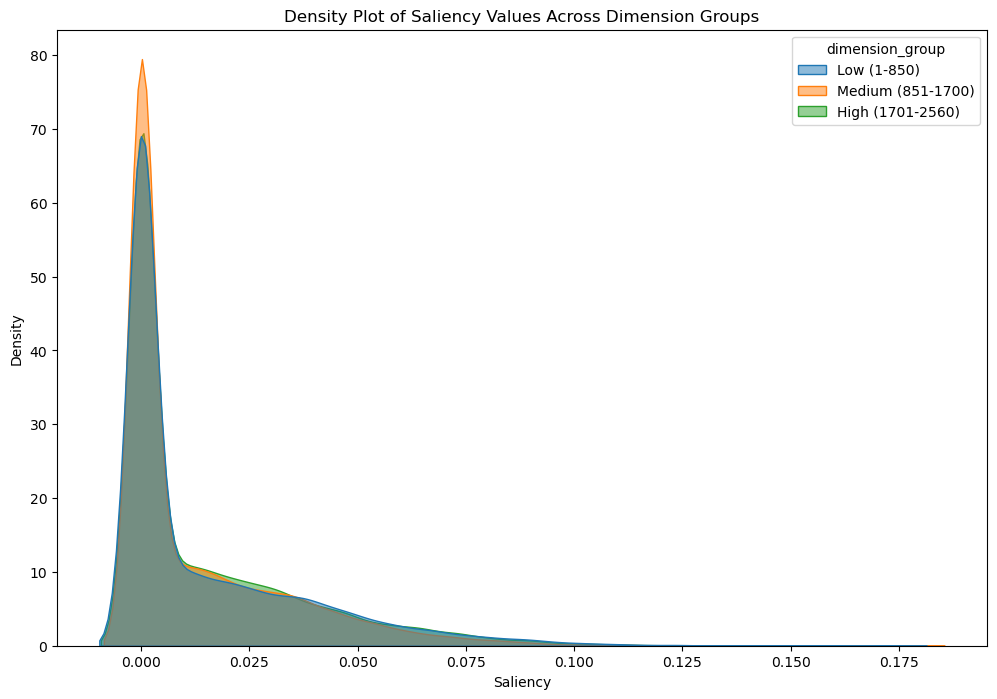

In [83]:
# boxplot for the distribution of saliencies of H48 per embedding dimension
h48_saliency = positive_saliencies[residue_index]  # Shape: (20, 2560)
# add the embedding dimension as a column
# 20x2560 -> 1x(20*2560)
h48_saliency_flattened = h48_saliency.T.flatten()

# create a dataframe for seaborn
df = pd.DataFrame(h48_saliency_flattened, columns=["saliency"])
df["embedding_dimension"] =  np.repeat(np.arange(2560), 20) 

df["dimension_group"] = pd.cut(
    df["embedding_dimension"],
    bins=[0, 850, 1700, 2560],
    labels=["Low (1-850)", "Medium (851-1700)", "High (1701-2560)"]
)

# Plot density plots for each group
plt.figure(figsize=(12, 8))
sns.kdeplot(
    data=df,
    x="saliency",
    hue="dimension_group",
    common_norm=False,
    fill=True,
    alpha=0.5
)
plt.title("Density Plot of Saliency Values Across Dimension Groups")
plt.xlabel("Saliency")
plt.ylabel("Density")
plt.show()

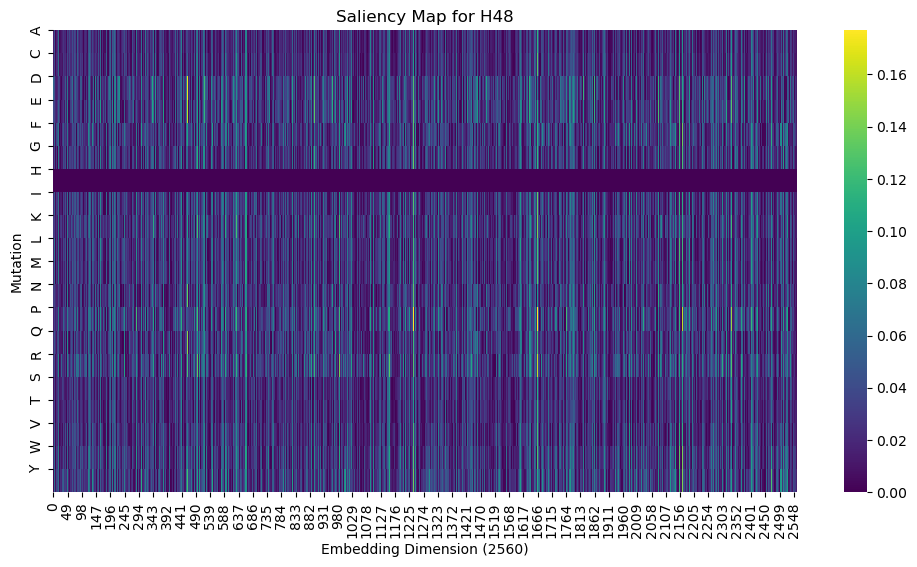

In [19]:
# out of curiosity: look into the saliency for H48 -> H47 due to common numbering scheme
residue_index = 47 - 1
assert sequence[residue_index] == 'H'
slice_saliency = saliency_map[residue_index] 
assert slice_saliency.shape == (20, 2560)

plt.figure(figsize=(12, 6))
sns.heatmap(slice_saliency, cmap='viridis', cbar=True)
plt.title(f"Saliency Map for H48")
plt.xlabel("Embedding Dimension (2560)")
plt.ylabel("Mutation")

# Change y-axis ticks to GEMME_ALPHABET
plt.yticks(ticks=np.arange(len(GEMME_ALPHABET)), labels=list(GEMME_ALPHABET))

plt.show()

In [20]:
# filter out the mutations with the 3 highest saliency values for H48
top_mutations = np.argsort(slice_saliency, axis=None)[-3:]
top_mutations = np.unravel_index(top_mutations, slice_saliency.shape)
top_mutations = list(zip(top_mutations[0], top_mutations[1]))
# map the indices to the amino acids according to the GEMME_ALPHABET
top_mutations = [(GEMME_ALPHABET[i], j) for i, j in top_mutations]
top_mutations

[('D', 461), ('P', 1239), ('P', 1666)]

In [21]:
# compare against vespag results
vespag_path = '/mnt/f/nicole/pla2_vespag/MF974418_1_Crotalus_atrox.csv'
vespag_scores = get_vespag_scores(vespag_path)
# average_vespag_scores 
vespag_scores['residue_index'] = vespag_scores['residue'].str[1:].astype(int)
average_vespag = vespag_scores.groupby('residue_index')['vespag'].mean().values

In [22]:
# take the average of the saliency map in the embedding dimension and in the mutation dimension
average_saliency = np.mean(saliency_map, axis=(1, 2))
average_saliency.shape

(122,)

In [23]:
vespag_scores[vespag_scores['residue_index'] == 47]['vespag'].shape

(19,)

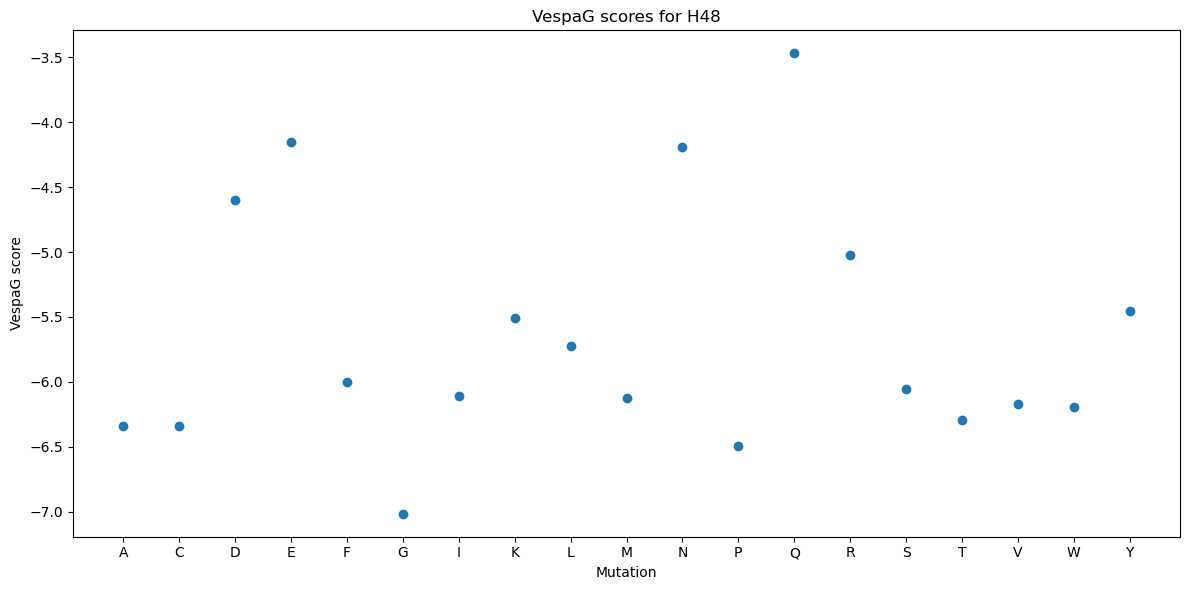

In [24]:
# sort these values in acccordance to the order given by the gemme alphabet 
vespag_scores['mutation'] = vespag_scores['mutation'].str[-1]
vespag_scores = vespag_scores.sort_values(by=['residue_index', 'mutation'])
vespag_scores = vespag_scores.reset_index(drop=True)
# what are the vespag values for H48?
vespag_scores[vespag_scores['residue_index'] == 47]
# plot these vespag scores 
plt.figure(figsize=(12, 6))

plt.scatter(x=range(len(vespag_scores[vespag_scores['residue_index'] == 47])), y=vespag_scores[vespag_scores['residue_index'] == 47]['vespag'])
plt.xticks(ticks=range(len(vespag_scores[vespag_scores['residue_index'] == 47])), labels=vespag_scores[vespag_scores['residue_index'] == 47]['mutation'])
plt.xlabel("Mutation")
plt.ylabel("VespaG score")
plt.title("VespaG scores for H48")

plt.tight_layout()
plt.show()

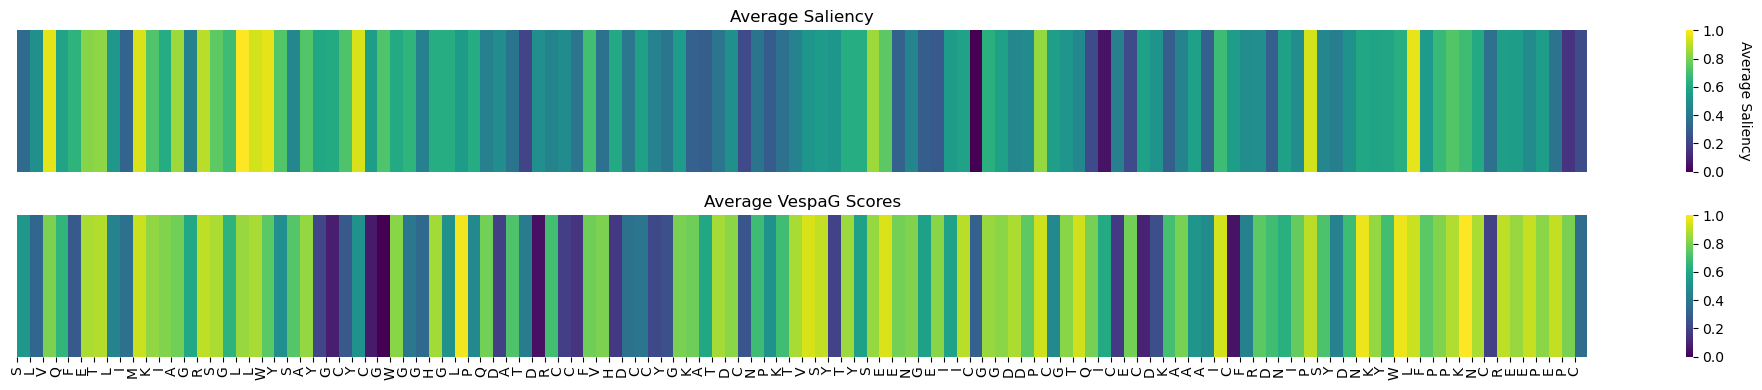

In [25]:
# compare against vespag results
vespag_path = '/mnt/f/nicole/pla2_vespag/MF974418_1_Crotalus_atrox.csv'
vespag_scores = get_vespag_scores(vespag_path)
# average_vespag_scores 
vespag_scores['residue_index'] = vespag_scores['residue'].str[1:].astype(int)
average_vespag = vespag_scores.groupby('residue_index')['vespag'].mean().values

# scale the average vespag and saliency into [0,1]
scaled_average_saliency = (average_saliency - np.min(average_saliency)) / (np.max(average_saliency) - np.min(average_saliency))
scaled_average_vespag = (average_vespag - np.min(average_vespag)) / (np.max(average_vespag) - np.min(average_vespag))

# Set up a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 4), gridspec_kw={'height_ratios': [1, 1]})

# Plot the average saliency
sns.heatmap(
    scaled_average_saliency.reshape(1, -1),
    cmap='viridis',
    cbar=True,
    xticklabels=list(sequence),
    yticklabels=False,
    ax=axes[0]
)
axes[0].set_title("Average Saliency")
axes[0].tick_params(axis='x', which='both', length=0)
axes[0].set_xticks([])
axes[0].set_xlabel("")
colorbar = axes[0].collections[0].colorbar
colorbar.set_label('Average Saliency', rotation=270, labelpad=20)

# Plot the average VespaG scores
sns.heatmap(
    scaled_average_vespag.reshape(1, -1),
    cmap='viridis',
    cbar=True,
    xticklabels=list(sequence),
    yticklabels=False,
    ax=axes[1]
)
axes[1].set_title("Average VespaG Scores")
axes[1].set_xticks(range(len(sequence)))
axes[1].set_xticklabels(list(sequence), rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [26]:
scaled_average_saliency.shape

(122,)

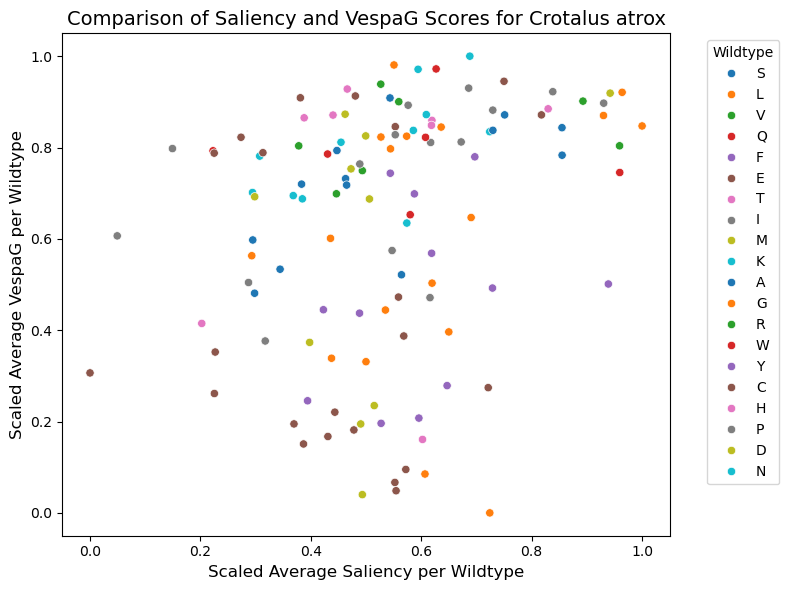

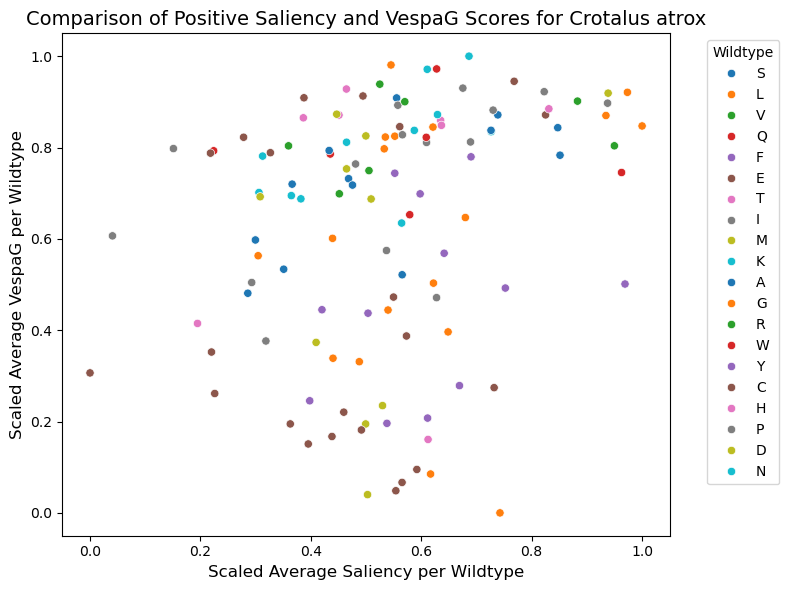

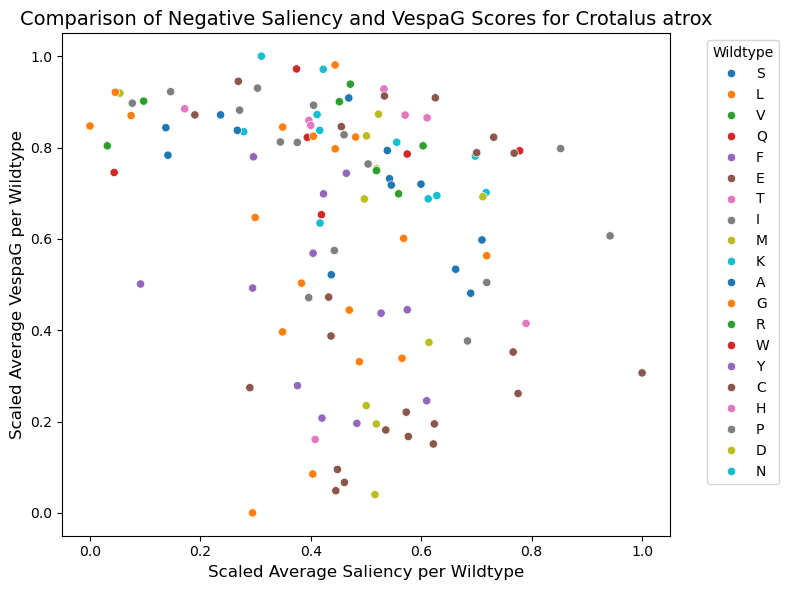

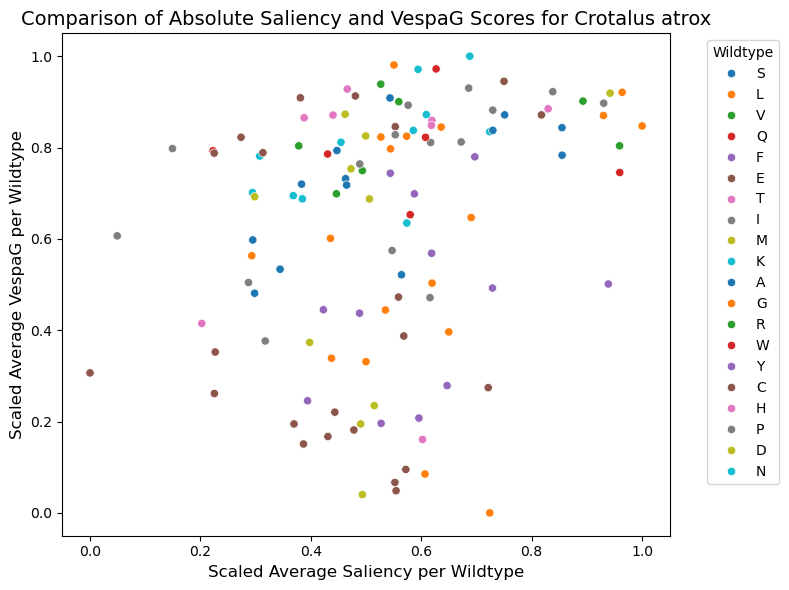

In [85]:
def plot_saliency_vs_vespag(scaled_average_saliency, scaled_average_vespag, sequence, title):
    # Create a DataFrame for seaborn
    df = pd.DataFrame({
        "scaled_average_saliency": scaled_average_saliency,
        "scaled_average_vespag": scaled_average_vespag,
        "residue": list(sequence)
    })

    # Scatter plot with hue based on residue type
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df,
        x="scaled_average_saliency",
        y="scaled_average_vespag",
        hue="residue",
        palette="tab10"
    )

    # Add labels and title
    plt.xlabel("Scaled Average Saliency per Wildtype", fontsize=12)
    plt.ylabel("Scaled Average VespaG per Wildtype", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(title="Wildtype", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# calculate the scaled_average_positive_saliency 
average_positive_saliency = np.mean(positive_saliencies, axis=(1, 2))
scaled_average_positive_saliency = (average_positive_saliency - np.min(average_positive_saliency)) / (np.max(average_positive_saliency) - np.min(average_positive_saliency))
average_negative_saliency = np.mean(negative_saliencies, axis=(1, 2))
scaled_average_negative_saliency = (average_negative_saliency - np.min(average_negative_saliency)) / (np.max(average_negative_saliency) - np.min(average_negative_saliency))
average_absolute_saliency = np.mean(absolute_saliencies, axis=(1, 2))
scaled_absolute_saliency = (average_absolute_saliency - np.min(average_absolute_saliency)) / (np.max(average_absolute_saliency) - np.min(average_absolute_saliency))                                                                                                                                      

plot_saliency_vs_vespag(scaled_average_saliency, scaled_average_vespag, sequence, "Comparison of Saliency and VespaG Scores for Crotalus atrox")
plot_saliency_vs_vespag(scaled_average_positive_saliency, scaled_average_vespag, sequence, "Comparison of Positive Saliency and VespaG Scores for Crotalus atrox")
plot_saliency_vs_vespag(scaled_average_negative_saliency, scaled_average_vespag, sequence, "Comparison of Negative Saliency and VespaG Scores for Crotalus atrox")
plot_saliency_vs_vespag(scaled_absolute_saliency, scaled_average_vespag, sequence, "Comparison of Absolute Saliency and VespaG Scores for Crotalus atrox")

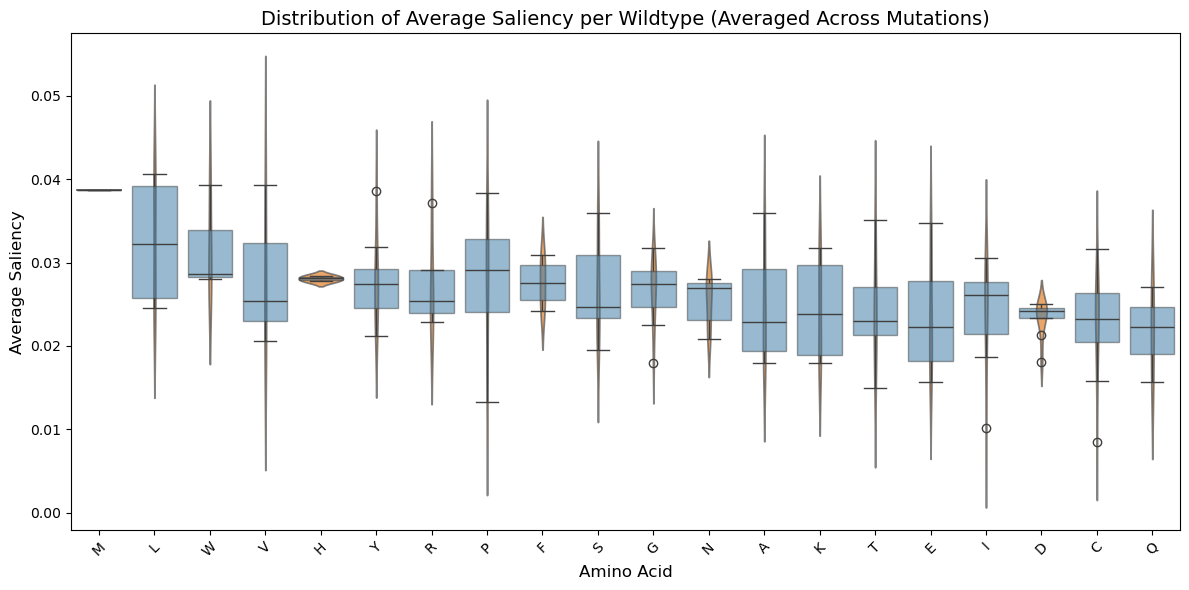

In [28]:
# take the average of the saliency map in the embedding dimension and in the mutation dimension
average_saliency = np.mean(saliency_map, axis=(1, 2))

df = pd.DataFrame({
    "residue": list(sequence),
    "saliency": average_saliency
})

# Calculate the average saliency for each residue
average_saliency_per_residue = df.groupby("residue")["saliency"].mean()

# Sort residues by their average saliency
sorted_residues = average_saliency_per_residue.sort_values(ascending=False).index

# Plot with the residues ordered by average saliency
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="residue", y="saliency", order=sorted_residues, boxprops=dict(alpha=.5))
sns.violinplot(data=df, x="residue", y="saliency", order=sorted_residues, inner=None, alpha=0.7)
plt.title("Distribution of Average Saliency per Wildtype (Averaged Across Mutations)", fontsize=14)
plt.xlabel("Amino Acid", fontsize=12)
plt.ylabel("Average Saliency", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

In [29]:
average_saliency = np.mean(saliency_map, axis=(0, 2))
average_saliency

array([0.02311187, 0.02157328, 0.02517297, 0.02580814, 0.02939647,
       0.02421096, 0.02830532, 0.02390667, 0.0277015 , 0.02388032,
       0.02565026, 0.02643394, 0.02574814, 0.02783596, 0.02761995,
       0.02371948, 0.02456752, 0.02450602, 0.02745223, 0.02964189])

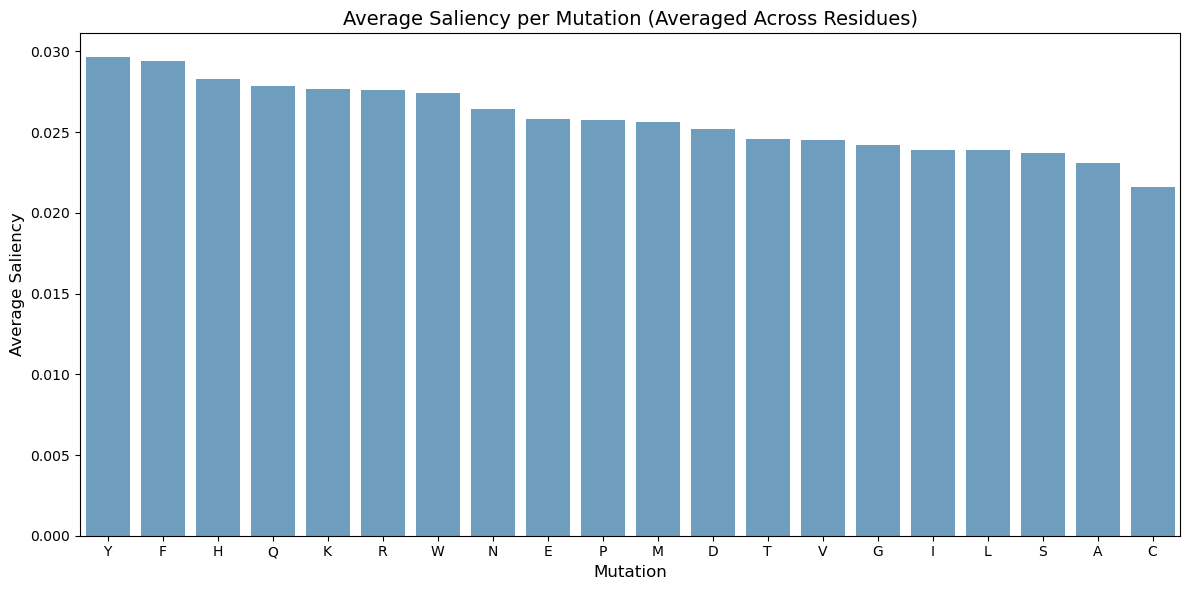

In [30]:
# Take the average of the saliency map in the embedding dimension and across residues
average_saliency = np.mean(saliency_map, axis=(0, 2))  # Shape: (20,)

# Create a DataFrame for the mutation saliencies
df = pd.DataFrame({
    "mutation": list(GEMME_ALPHABET),
    "saliency": average_saliency
})

# Sort the DataFrame by saliency in descending order
df = df.sort_values(by="saliency", ascending=False)

# Plot as a barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="mutation", y="saliency", alpha=0.7)
plt.title("Average Saliency per Mutation (Averaged Across Residues)", fontsize=14)
plt.xlabel("Mutation", fontsize=12)
plt.ylabel("Average Saliency", fontsize=12)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()
